In [10]:
# importing all the dependencies
%matplotlib inline
from IPython.display import display
from IPython.display import Image
import sys
import math
import numpy as np
import argparse
import os
import shutil
import scipy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm, colors
from scipy import integrate
import scipy.constants as cst
import h5py

# the more important ones
from itertools import product as itp
from pythtb import *
from triqs.lattice.tight_binding import TBLattice
import sympy as sp
import warnings

In [82]:
def sympyfy(w90_triqs, analytical = True, precision = 6):
    r"""
    returns the analytical form of the momentum space hamiltonian of the tight-binding model 
    from a tight-binding lattice object, by utilizing Fourier series
    
    Parameters
    ----------
    w90_triqs: triqs TBLattice object
        triqs tight binding object
    analytical: boolean, default = True
        a boolean which will cause the function will return an analytical Hamiltonian, when true, and 
        an numerical Hamiltonian otherwise
    precision: integer, default = 6
        An integer that specifies the decimal point precision of the floating point hopping amplitudes of
        the electrons involved in the hoppings
        Wannier90's default precision is 10^-6 which is why the default precision is 6
        The user might want to decrease the default precision to ensure that similar hopping amplitudes
        especially those tied to symmetrical hoppings across the crysal lattice are easily recognizable
    
    Returns
    -------
    Hk: NumPy array
        The hamiltonian of the tight-binding model in momentum space. This can be returned either in
        numerical form (Hk_numerical) or reduced analytical form (Hk) depending the user's preference.
        The default output, which depends on the optional analytical parameter, is the reduced analytical form
        The numerical form only depends on the k-space vector components, i.e., the lattice constants and
        lattice vectors are expressed numerically
        The analytical form depends on the k-space vector components alongside the lattice vectors too

    """

    # imaginary number
    I = sp.I

    # matrix from the axis directions in momentum space
    kx, ky, kz = sp.symbols("kx ky kz", real = True)
    k_space_matrix = sp.Matrix([kx, ky, kz])

    # symbolic dot product representation between the lattice unit vectors
    # and the momentum space matrix
    a1k, a2k, a3k = sp.symbols("a1k a2k a3k", real = True)
    lattice = sp.Matrix([a1k, a2k, a3k])

    # the number of orbitals involved in the electron hoppings
    num_orb = w90_triqs.n_orbitals

    # dictionary containing details about the hopping of the electrons
    TB_lat_obj_hops = w90_triqs.hoppings 

    # maximum hopping distances of electrons in each of the axial directions
    max_x, max_y, max_z = list(np.max(np.array(list(TB_lat_obj_hops.keys())), axis = 0))

    # number of cells involved in the hopping of electrons in each of the axial directions
    num_cells_x, num_cells_y, num_cells_z = [2 * max_coord + 1 for max_coord in [max_x, max_y, max_z]]
    
    # basis of the 5D tensor real-space Hamiltonian
    Hrij = np.zeros((num_cells_x, num_cells_y, num_cells_z, num_orb, num_orb), dtype = sp.exp)

    # looping through the hopping parameters of the electrons involved in the inter-orbital hoppings
    # key represents the cell coordinates of where the electrons hop to relative to the home unit cell
    # hopping represents the matrix with the embedded hopping amplitudes
    for key, hopping in TB_lat_obj_hops.items():
        rx, ry, rz = key
        # reduce floating point precision of hopping parameters to 3 decimal places
        hopping = np.around(hopping, precision)
        Hrij[rx + max_x, ry + max_y, rz + max_z] = hopping

    # basis of the exponential term in the calculation of Hk
    Hexp = np.empty_like(Hrij, dtype = sp.exp)

    # perform the Fourier transform
    for xi, yi, zi in itp(range(num_cells_x), range(num_cells_y), range(num_cells_z)):
        coefficients = np.array([xi - max_x, yi - max_y, zi - max_z])
        r = lattice.dot(coefficients)
        eikr = sp.exp(-I * r)
        Hexp[xi, yi, zi, :, :] = eikr

    # summation over all real space axes
    Hk = np.sum(Hrij * Hexp, axis = (0, 1, 2))
    
    # rewriting the exponential terms in the analytical expression in terms of 
    for i, j in itp(range(num_orb), repeat = 2):
        Hk[i, j] = Hk[i, j].rewrite(sp.cos)

    # dealing with the numerical Hamiltonian
    # we convert it to a SymPy matrix to use the substitutions method available in SymPy
    Hk_numerical = sp.Matrix(Hk)

    # matrix containing the displacement vectors
    TB_lat_obj_units = w90_triqs.units

    # obtaining the individual displacement vectors
    a1 = np.around(TB_lat_obj_units[0], precision)
    a2 = np.around(TB_lat_obj_units[1], precision)
    a3 = np.around(TB_lat_obj_units[2], precision)

    # numerical dot products between the unit vectors
    # and the momentum space matrix
    a1k_numerical = a1.dot(k_space_matrix)[0]
    a2k_numerical = a2.dot(k_space_matrix)[0]
    a3k_numerical = a3.dot(k_space_matrix)[0]
    
    # performing the numerical dot product substitutions
    Hk_numerical = Hk_numerical.subs(a1k, a1k_numerical)
    Hk_numerical = Hk_numerical.subs(a2k, a2k_numerical)
    Hk_numerical = Hk_numerical.subs(a3k, a3k_numerical)

    # converting the numerical Hamiltonian to a NumPy array from a SymPy matrix
    Hk_numerical = np.array(Hk_numerical)

    def _has_complex_exponential_sympy(matrix):
        """
        Checks if a NumPy array containing SymPy elements has a complex exponential element.

        Args:
            matrix (NumPy array): The input NumPy array containing SymPy elements
        
        Returns:
            bool: True if the matrix array contains a complex exponential element, False otherwise.

        """

        for sublist in matrix:
            for element in sublist:
                if element.is_complex and element.has(sp.exp):
                    return True
        return False
    
    def _is_hermitian_sympy(matrix):
        """
        Checks if a NumPy array containing SymPy elements is hermitian

        Args:
            matrix (NumPy array): The input NumPy array containing SymPy elements
        
        Returns:
            bool: True if the matrix is a hermitian, False otherwise

        """
        
        n = matrix.shape[0]
        for i in range(n):
            for j in range(n):
                if matrix[i, j] != matrix[j, i].conjugate():
                    return False
        return True
    
    # warning indicating when the output Hamiltonian is not hermitian
    if _is_hermitian_sympy(Hk) == False or _is_hermitian_sympy(Hk_numerical) == False:
        return warnings.warn("The resulting Hamiltonian is not hermitian.")

    # warning indicating when the Hamiltonian contains a complex exponential element
    if _has_complex_exponential_sympy(Hk_numerical) or _has_complex_exponential_sympy(Hk):
        return warnings.warn("""Your expression has a complex exponential. 
                                Choosing a different unit cell could make 
                                your Hamiltonian expression real.""")
    
    # returning the analytical or numerical form of the Hamiltonian
    # depending on the user's preference
    if analytical:
        return Hk
    return Hk_numerical

In [83]:
from triqs.lattice.utils import TB_from_pythTB
w90_input = w90('La2CuO4 Files', 'lco')
fermi_ev = 12.7367
w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.05, max_distance = None)
w90_triqs = TB_from_pythTB(w90_model)


In [84]:
print(w90_triqs.hoppings)

{(0, 0, 0): array([[0.158922+0.j]]), (0, 1, 1): array([[-0.440321+0.j]]), (0, -1, -1): array([[-0.440321+0.j]]), (1, 0, 1): array([[-0.440321+0.j]]), (-1, 0, -1): array([[-0.440321+0.j]])}


In [87]:
# calling the functions in different scenarios
print("The analytical expression \n", sympyfy(w90_triqs, analytical = True, precision = 3))
print("The numerical expression \n", sympyfy(w90_triqs, analytical = False, precision = 3))
# print("The less precise numerical expression \n", sympyfy(w90_triqs, False, 3))

The analytical expression 
 [[-0.88*cos(a1k + a3k) - 0.88*cos(a2k + a3k) + 0.159]]
The numerical expression 
 [[-0.88*cos(3.818*kx) - 0.88*cos(3.818*ky) + 0.159]]


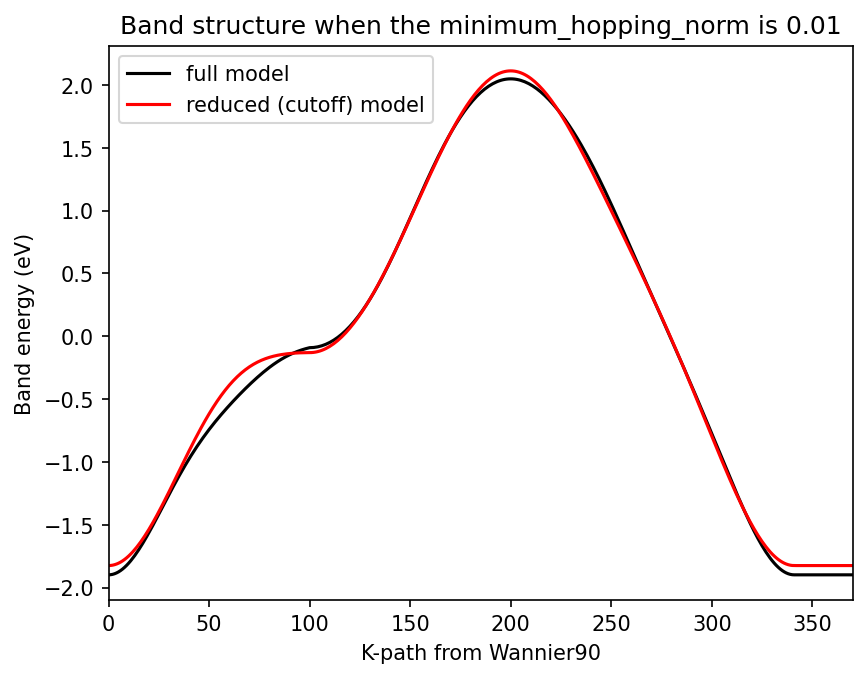

In [94]:
def compareBandStructure(w90_input, fermi_ev): 
    # get band structure from wannier90
    # BLACK - the full model
    # the purpose of this function is to compare the interpolation in W90 with that in PythTB
    # returns kpts (k-points in reduced coordinates used in the interpolation in W90 code) and
    # ene (energies interpolated by W90 in the form of ene[band, kpoint])
    (w90_kpt, w90_evals) = w90_input.w90_bands_consistency()

    # get the simplified model by introducing cutoff parameters
    min_hopping_norm = 0.01
    w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.01, max_distance = None)

    # RED - the reduced model
    # solve simplified model on the same k-path as in wannier90
    # solves for eigenvalues and (optionally) eigenvectors of the TB model on a given 1D list of k-vectors
    int_evals = w90_model.solve_all(w90_kpt)


    # plotting the comparison of the 2 models


    # the plotting
    fig, ax = plt.subplots(dpi = 150)

    for i in range(w90_evals.shape[0]):
        x_axis = list(range(w90_evals.shape[1]))
        y_axis = w90_evals[i] - fermi_ev
        ax.plot(x_axis, y_axis, "k-", zorder = -100)

    # the reduced model
    for i in range(int_evals.shape[0]):
        ax.plot(list(range(int_evals.shape[1])), int_evals[i], "r-", zorder = -50)
    
    ax.set_title("Band structure when the minimum_hopping_norm is " + str(min_hopping_norm))
    ax.set_xlim(0, int_evals.shape[1]-1)
    ax.set_xlabel("K-path from Wannier90")
    ax.set_ylabel("Band energy (eV)")
    
    ax.legend(["full model", "reduced (cutoff) model"])


# calling the function
lanthanum_w90_input = w90('La2CuO4 Files', 'lco')
compareBandStructure(lanthanum_w90_input, 12.7367)